# ULMFiT

In [4]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime

from pathlib import Path

from fastai import *
from fastai.text import *

## Load Data

In [47]:
model_title = 'ULMFiT_3.0-108k'
MODEL_PATH = Path(f'../data/processed/{model_title}')
MODEL_PATH.mkdir(exist_ok=True)

In [48]:
data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                      bs=128,
                                      max_vocab=10000)

print(data_lm.train_ds.vocab_size)

10002


## Training

In [49]:
TRAIN = False
GPU = True

In [50]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [51]:
learn = RNNLearner.language_model(data_lm,
                                  pretrained_model=URLs.WT103,
                                  drop_mult=0.5)
my_cb = SaveModel(learn, model_name='ULMFiT_3.0-108k')

In [11]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

Total time: 34:20
epoch  train_loss  valid_loss  accuracy
1      3.518044    3.366549    0.377193  (34:20)



In [22]:
if TRAIN:
    learn.unfreeze()
    learn.fit_one_cycle(10, 1e-3, callbacks=[my_cb])

Total time: 7:12:31
epoch  train_loss  valid_loss  accuracy
1      3.249451    3.150680    0.411303  (43:12)
2      3.088657    3.031554    0.428169  (42:51)
3      2.997940    2.962431    0.437647  (43:07)
4      2.898715    2.904743    0.445536  (42:59)
5      2.839530    2.867735    0.450398  (43:17)
6      2.774205    2.838963    0.454689  (43:35)
7      2.796032    2.819284    0.457577  (43:42)
8      2.718747    2.800721    0.460300  (43:17)
9      2.677433    2.793718    0.461533  (42:59)
10     2.694748    2.791559    0.461865  (43:27)



In [24]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  2.7915585


#### Learning Loss

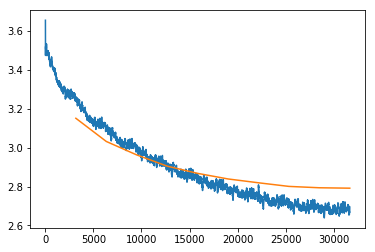

In [40]:
learn.recorder.plot_losses()

## Model Load

In [52]:
def cpu_load(self, name:PathOrStr):
    """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
       We need these because the fastai load function doesn't allow for a remapping of the storage location."""
    self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [53]:
if not GPU:
    learn.cpu_load(f'{model_title}_best')
else:
    learn.load(f'{model_title}_best')

## Text Generation

In [56]:
def generate_text(learner, seed_text=['xbos'], max_len=500, GPU=False, context_length=20):
    """Generates text with a given learner and prints string to console.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit

    Returns
    -------
    None : NoneType
        Doesn't return anything, prints string to console
    """
        
    model = learner.model
    
    if isinstance(seed_text, str):
        seed_text = seed_text.split(' ')
    
    if GPU:
        context = LongTensor(data_lm.train_ds.vocab.numericalize(seed_text)).view(-1,1).cuda()
    else:
        context = LongTensor(data_lm.train_ds.vocab.numericalize(seed_text)).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    # reset model's hidden state
    # we don't want to carry over old contexts
    model.reset()
    model.eval()

    #loop over max length of words
    for _ in range(max_len):
        # forward pass the "context" into the model
        result, *_ = model(context[-context_length:])
        result = result[-1]

        # set unk and pad to 0 prob
        # i.e. never pick unknown or pad
        result[0] = -np.inf
        result[1] = -np.inf

        # softmax and normalize
        probabilities = F.softmax(result, dim=0)
        probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
        probabilities /= np.sum(probabilities) # solve rounding issues for multinom function

        # draw multinom and add to context
        token_index = np.argmax(np.random.multinomial(1, probabilities))
        
        if GPU:
            token_index = LongTensor([token_index]).view(-1, 1).cuda()
        else:
            token_index = LongTensor([token_index]).view(-1, 1).cpu()

        context = torch.cat((context, token_index))    
        
        # print word
        word = data_lm.valid_ds.vocab.textify([token_index])

        if word == 'xeol':
            word = '\n'
        elif 'xbol' in word:
            continue
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')    

In [65]:
generate_text(learn, GPU=GPU, seed_text='xbos xbol [verse-1]', max_len=1200, context_length=70)


 fall into love revenge 
 she 'll try it again 
 what the hell will she say ? 
 i 'd take her in 
 but baby once their face is still cast 
 old heaven 
 
 [chorus] 
 bury my heart 
 where my heart 's been (love is her ) 
 where 's my heart 
 where she 's gone ? 
 where were my lover 
 xeos
